<a href="https://colab.research.google.com/github/ethanchoi1116/probabilistic-deep-learning/blob/main/notebooks/zero_inflated_poisson_nonlinear_regression_on_camper_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-Inflated Poisson Nonlinear Regression on `camper` Dataset
---

## Import Necessary Libraries

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt
import seaborn as sns
tfd = tfp.distributions

## Load `camper` Dataset

In [ ]:
# the camer dataset
# "nofish","livebait","camper","persons","child","xb","zg","count"
data = np.loadtxt("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv",delimiter=",", skiprows=1)
X = np.array(data[:,1:5], dtype=np.float32)
y = np.array(data[:,7], dtype=np.float32)
print(X.shape, y.shape)

(250, 4) (250,)


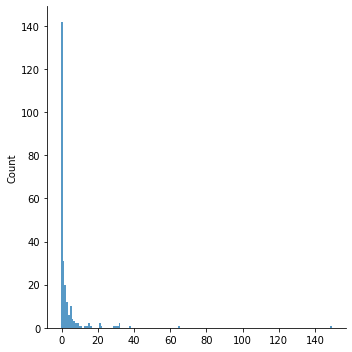

In [ ]:
# target distribution
sns.displot(x=y, discrete=True, edgecolor='none')
plt.show()

In [ ]:
# access zeros
print(f"% of zeros: {100 * np.mean(y == 0)}")

% of zeros: 56.8


In [ ]:
# train val test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, y_test[0:10], y_train[0:10]

((200, 4),
 (200,),
 (50, 4),
 (50,),
 array([0., 0., 2., 2., 0., 0., 0., 0., 1., 0.], dtype=float32),
 array([ 6.,  1.,  6.,  1.,  3.,  1.,  0., 15.,  0.,  2.], dtype=float32))

# Writing ZIP NN Model for dataset using `TFP`

In [ ]:
class ZIPRegNet(Model):
    # model class for modeling nonlinear ZIP
    def __init__(self):
        super().__init__()
        tf.keras.backend.clear_session()
        self.h_lam_1 = Dense(4, activation="relu")
        self.h_pi_1 = Dense(4, activation="relu")
        self.lam = Dense(1, activation="exponential")
        self.pi = Dense(1, activation="sigmoid")
        self.concat = Concatenate()
        self.dist = tfp.layers.DistributionLambda(self.zip)

    def zip(self, params):
        lam = tf.squeeze(params[...,0:1])
        pi = params[...,1:2]
        pis = tf.concat([pi, 1-pi], axis=1)
        dist = tfd.Mixture(
            cat = tfd.Categorical(probs=pis),
            components=[
                        tfd.Deterministic(loc=tf.zeros_like(lam)),
                        tfd.Poisson(rate=lam)
            ]
        )

        return dist

    def call(self, x):
        h_lam = self.h_lam_1(x)
        h_pi = self.h_pi_1(x)
        lam = self.lam(h_lam)
        pi = self.pi(h_pi)
        params = self.concat([lam, pi])
        dist = self.dist(params)

        return dist

def NLL(y, dist):
    # loss as a negative log likelihood given observation
    return -dist.log_prob(tf.reshape(y, (-1,)))

In [ ]:
# compiling model
model = ZIPRegNet()
model.build(input_shape=(None, X_train.shape[1]))
model.compile(optimizer=Adam(learning_rate=0.001), loss=NLL)
model.summary()

Model: "zip_reg_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  20        
_________________________________________________________________
dense_1 (Dense)              multiple                  20        
_________________________________________________________________
dense_2 (Dense)              multiple                  5         
_________________________________________________________________
dense_3 (Dense)              multiple                  5         
_________________________________________________________________
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 50
Trainable params: 50
Non-trainable params: 0
___________________________________________________________

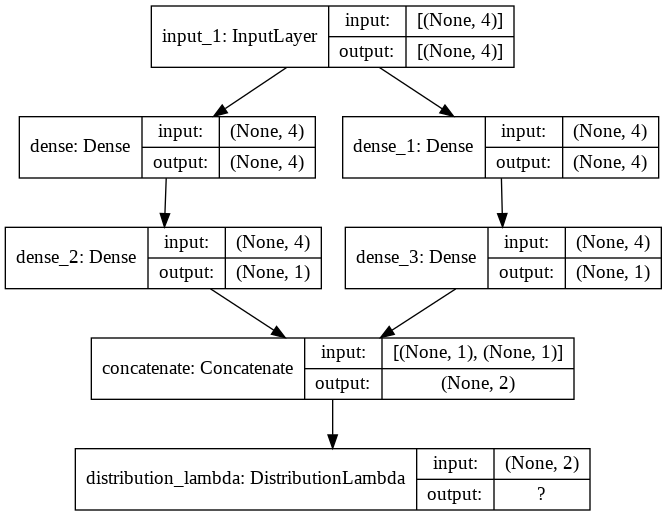

In [ ]:
# visualization of model architecture
def build_graph(model):
        x = Input(shape=(X_train.shape[1],))

        return Model(inputs=[x], outputs=model.call(x))

tf.keras.utils.plot_model(build_graph(model), "model.png", show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, verbose=0, validation_data=(X_test, y_test), callbacks=[TqdmCallback(verbose=0)])

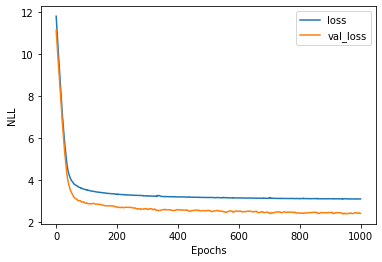

In [ ]:
# loss trajectory
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.ylabel("NLL")
plt.xlabel("Epochs")
plt.show()

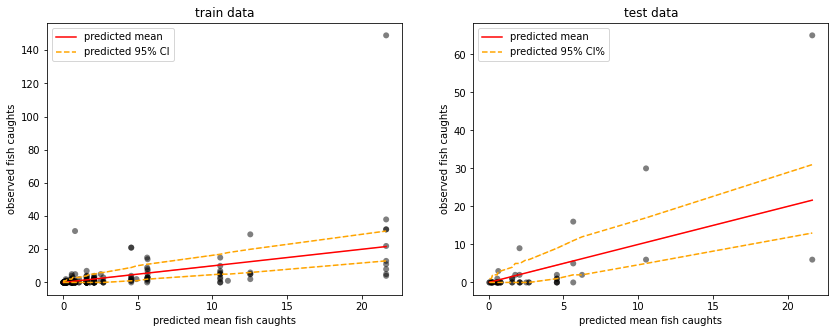

MSE : 7.582618236541748, MAE: 3.302229881286621


In [ ]:
# prediction evaluation
from scipy.stats import poisson
mean_pred_train = model(X_train).mean().numpy().flatten()
lower_train=poisson.ppf(0.025, mean_pred_train)
upper_train=poisson.ppf(0.975, mean_pred_train)
mean_pred_test = model(X_test).mean().numpy().flatten()
lower_test=poisson.ppf(0.025, mean_pred_test)
upper_test=poisson.ppf(0.975, mean_pred_test)
# train data
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=mean_pred_train, y=y_train, color="black", alpha=0.5, edgecolor="none")
sns.lineplot(x=mean_pred_train, y=mean_pred_train, color="red", label="predicted mean")
sns.lineplot(x=mean_pred_train, y=lower_train, color="orange", linestyle="dashed", label="predicted 95% CI")
sns.lineplot(x=mean_pred_train, y=upper_train, color="orange", linestyle="dashed")
plt.xlabel("predicted mean fish caughts")
plt.ylabel("observed fish caughts")
plt.legend()
plt.title("train data")
# test data
plt.subplot(1, 2, 2)
sns.scatterplot(x=mean_pred_test, y=y_test, color="black", alpha=0.5, edgecolor="none")
sns.lineplot(x=mean_pred_test, y=mean_pred_test, color="red", label="predicted mean")
sns.lineplot(x=mean_pred_test, y=lower_test, color="orange", linestyle="dashed", label="predicted 95% CI%")
sns.lineplot(x=mean_pred_test, y=upper_test, color="orange", linestyle="dashed")
plt.xlabel("predicted mean fish caughts")
plt.ylabel("observed fish caughts")
plt.legend()
plt.title("test data")
plt.show()
# metrics
mse=np.sqrt(np.mean((y_test - mean_pred_test)**2))
mae=np.mean(np.abs(y_test - mean_pred_test)) 
print(f"MSE : {mse}, MAE: {mae}")

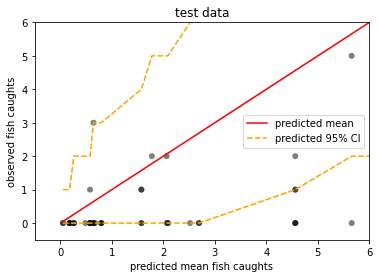

In [ ]:
# zoomed comparison
# note that 2.5% percentile is zero over the quite long range
# test data
sns.scatterplot(x=mean_pred_test, y=y_test, color="black", alpha=0.5, edgecolor="none")
sns.lineplot(x=mean_pred_test, y=mean_pred_test, color="red", label="predicted mean")
sns.lineplot(x=mean_pred_test, y=lower_test, color="orange", linestyle="dashed", label="predicted 95% CI")
sns.lineplot(x=mean_pred_test, y=upper_test, color="orange", linestyle="dashed")
plt.xlabel("predicted mean fish caughts")
plt.ylabel("observed fish caughts")
plt.legend()
plt.title("test data")
plt.xlim([-0.5, 6])
plt.ylim([-0.5, 6])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


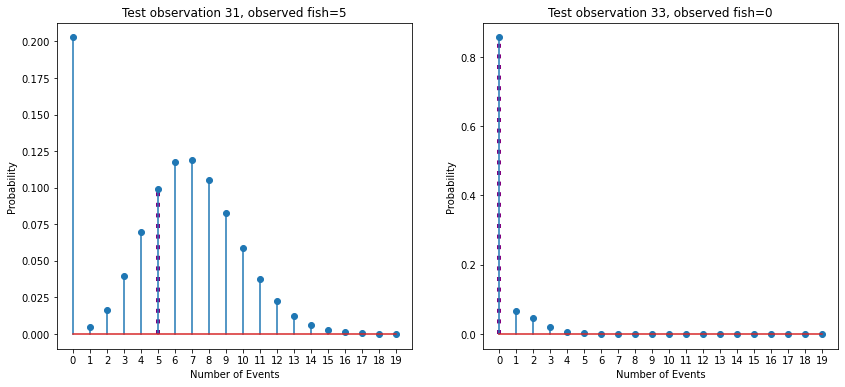

In [ ]:
# observation wise analysis
probs=model(X_test).prob(np.arange(0,20,1).reshape(20,1)).numpy()
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.stem(np.arange(0,20,1),probs[:,31])
plt.vlines(np.expand_dims(y_test,axis=1)[31], ymin=0, ymax=probs[np.int(y_test[31]),31],linestyle="dotted",color="purple",linewidth=4)
plt.xticks(np.arange(0,20,1))
plt.xlabel("Number of Events")
plt.ylabel("Probability")
plt.title("Test observation 31, observed fish=5")

plt.subplot(1,2,2)
plt.stem(np.arange(0,20,1),probs[:,33])
plt.vlines(np.expand_dims(y_test,axis=1)[33], ymin=0, ymax=probs[np.int(y_test[33]),33],linestyle="dotted",color="purple",linewidth=4)
plt.xticks(np.arange(0,20,1))
plt.xlabel("Number of Events")
plt.ylabel("Probability")
plt.title("Test observation 33, observed fish=0")
plt.show()